## Importing the Libraries

In [47]:
# Importing required libraries
import re
import string
import nltk
import graphviz
import pydot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
import bert
import tensorflow as tf
import tensorflow_hub as hub

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, TFBertForSequenceClassification
from nltk.stem import WordNetLemmatizer
from gensim.models import fasttext
from gensim.models.fasttext import FastText
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Venkat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Venkat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Venkat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Disaster Tweets Analysis

   Classification of the tweets whether the tweet is about a disaster that happened or whether it is just normal tweet.

## Loading the Dataset

In [2]:
# Loading the Dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head(), test_data.head()

(   id keyword location                                               text  \
 0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
 1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
 2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
 3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
 4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
 
    target  
 0       1  
 1       1  
 2       1  
 3       1  
 4       1  ,
    id keyword location                                               text
 0   0     NaN      NaN                 Just happened a terrible car crash
 1   2     NaN      NaN  Heard about #earthquake is different cities, s...
 2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
 3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
 4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan)

## Exploring the Data 

In [3]:
# Function to explore the types of data and missing values in the dataset
def data_explore(data, train=1):
    print('Number of inputs in data: ' + str(len(data)))
    print('Number of missing value in each column: \n', data.isnull().sum())
    
    if train:
        data['target'].value_counts().plot(kind='bar', title='Target Distribution')
        
    keyword_percent = ((data['keyword'].isnull().sum()) / len(data)) * 100
    location_percent = float(((data['location'].isnull().sum()) / len(data)) * 100)
    
    print('Unique number of Keywords: ', str(data['keyword'].nunique()))
    print('Unique number of Locations: ', str(data['location'].nunique()))

    print('Percentage of missing values in Keyword Column: ', str(keyword_percent))
    print('Percentage of missing values in Location Column: ', str(location_percent))

Number of inputs in data: 7613
Number of missing value in each column: 
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Unique number of Keywords:  221
Unique number of Locations:  3341
Percentage of missing values in Keyword Column:  0.8012610009194797
Percentage of missing values in Location Column:  33.27203467752528


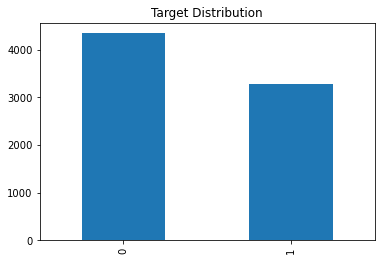

In [4]:
# Training set
data_explore(train_data)

In [5]:
# test set
data_explore(test_data, 0)

Number of inputs in data: 3263
Number of missing value in each column: 
 id             0
keyword       26
location    1105
text           0
dtype: int64
Unique number of Keywords:  221
Unique number of Locations:  1602
Percentage of missing values in Keyword Column:  0.796812749003984
Percentage of missing values in Location Column:  33.86454183266932


## Plotting the data distribution

Text(0.5, 1.0, 'Location Distribution for train')

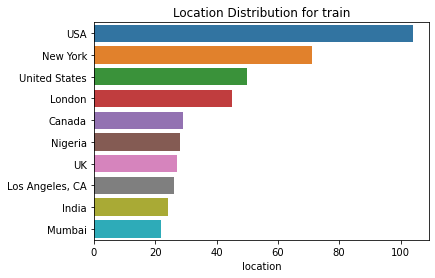

In [6]:
# Graph for Train set for location distribution
sns.barplot(y=train_data['location'].value_counts()[:10].index, 
            x=train_data['location'].value_counts()[:10],
            orient='h').set_title('Location Distribution for train')

Text(0.5, 1.0, 'Location Distribution for test')

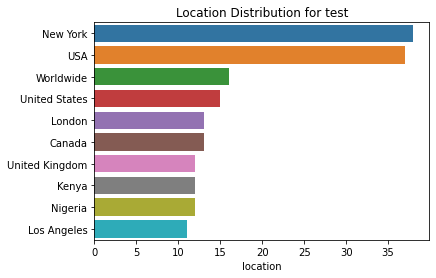

In [7]:
# Graph for Test set for location distribution
sns.barplot(y=test_data['location'].value_counts()[:10].index, 
            x=test_data['location'].value_counts()[:10],
            orient='h').set_title('Location Distribution for test')

## Preprocessing the text data for One Hot Encoding

In [8]:
# Preprocessing text into input format
def preprocess(text):
    # Removing Punctuation from the text
    punct = [words for words in text if words not in string.punctuation ]
    words = ''.join(punct)
    
    # Tokenizing the text
    tokens = nltk.word_tokenize(words)
    
    # Removing the stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    stop_tokens = [word for word in tokens if word not in stopwords]
    stop_tokens = [word.lower() for word in stop_tokens]
    
    # Appying Lemmatization to the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in stop_tokens])
    
    # Removing emojis, emails, numbers
    
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', lemmatized_output, flags=re.MULTILINE)
    text = re.sub('<.*?>+', '', text)
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F" 
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags = re.UNICODE)
    
    text = regrex_pattern.sub(r'',text)
    text = ''.join([i for i in text if not i.isdigit()])
    
    return text

In [9]:
train_data['preprocess_text'] = train_data['text'].apply(lambda x: preprocess(x))
test_data['preprocess_text'] = test_data['text'].apply(lambda x: preprocess(x))

In [10]:
# Preprocessed training data
train_data.head()

,id,keyword,location,text,target,preprocess_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all resident asked shelter place notified offi...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cali...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent photo ruby alaska smoke wildfire...


In [11]:
# Preprocessed test data
test_data.head()

,id,keyword,location,text,preprocess_text
0,0,NaN,NaN,Just happened a terrible car crash,just happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


In [12]:
# Converting the each input into one hot representation
representation = [one_hot(sentence, 100000) for sentence in train_data['preprocess_text']]
len(representation)

7613

In [13]:
# Padding the data and converting all the inputs into same length
embedded_matrix = pad_sequences(representation, padding='pre', maxlen=15)
embedded_matrix

array([[    0,     0,     0, ..., 52372, 51821, 27442],
       [    0,     0,     0, ..., 78944, 93814, 89213],
       [    0,     0, 28696, ..., 56901, 69445, 24106],
       ...,
       [    0,     0,     0, ..., 64827, 90916, 84994],
       [    0, 48135, 36286, ..., 65189, 10857, 35290],
       [    0,     0,     0, ..., 36203,  8521, 91594]])

In [14]:
# Train validation split of the training data for validation 
X_train, X_test, y_train, y_test = train_test_split(embedded_matrix, train_data['target'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6090, 15), (1523, 15), (6090,), (1523,))

## Using Bi-Directional LSTM model for prediction

In [15]:
# Sequential model with embedding layer and BiLSTM Layer for one hot embedding
lstm_model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=100000,
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.3, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

lstm_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          6400000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 6,474,369
Trainable params: 6,474,369
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = lstm_model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=10)

Epoch 1/3
609/609 [==============================] - 84s 124ms/step - loss: 0.6635 - accuracy: 0.6079 - val_loss: 0.5431 - val_accuracy: 0.7866
Epoch 2/3
609/609 [==============================] - 74s 121ms/step - loss: 0.4210 - accuracy: 0.8340 - val_loss: 0.4702 - val_accuracy: 0.7991
Epoch 3/3
609/609 [==============================] - 74s 121ms/step - loss: 0.2878 - accuracy: 0.8936 - val_loss: 0.4941 - val_accuracy: 0.7879


              precision    recall  f1-score   support

     Class 0       0.80      0.85      0.82       874
     Class 1       0.78      0.71      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



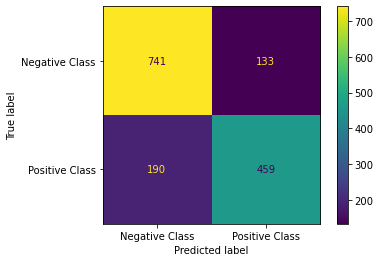

In [17]:
# Performace metrics for LSTM model
y_pred = lstm_model_1.predict(X_test)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
report_lstm_1 = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
print(report_lstm_1)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative Class', 'Positive Class'])
disp.plot(values_format='d')

## Preprocessing the data using Fasttext

In [18]:
# Preprocessing the text for fasttext
train_data['preprocess_text'] = train_data['text'].apply(lambda x: nltk.word_tokenize(preprocess(x)))
train_data.head()

,id,keyword,location,text,target,preprocess_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deed, reason, earthquake, may, allah, fo..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, resident, asked, shelter, place, notifie..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfire, evacuation, order,..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, photo, ruby, alaska, smoke, ..."


## Training the Fasttext model

In [ ]:
# Training the Fasttext Model using the dataset
embedding_size = 120
window_size = 50
min_word = 5
down_sampling = 1e-2

fast_model = FastText(sentences=train_data['preprocess_text'],
                      vector_size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      epochs=300)

fast_model.save('fast_text.model')

In [ ]:
# Fasttext vector representation for the word
print(fast_model.wv['ablaze'], fast_model.wv['ablaze'].shape)

In [19]:
# Loading the Fasttext model
ld_fs_model = FastText.load('fast_text.model')
print('Fasttext Model is loaded')

Fasttext Model is loaded


In [20]:
# finding the similar words using fasttext
ld_fs_model.wv.most_similar('disaster', topn=10)

[('natural', 0.7408626079559326),
 ('typhoondevastated', 0.5278961658477783),
 ('declaration', 0.5219874978065491),
 ('nuclear', 0.516944408416748),
 ('saipan', 0.4944591224193573),
 ('nytimes', 0.4886290729045868),
 ('marians', 0.48073628544807434),
 ('fukushima', 0.44203171133995056),
 ('increased', 0.43661612272262573),
 ('standard', 0.42087066173553467)]

In [21]:
# Plotting the fasttext model
def tsne_plot(for_word, w2v_model):
    # trained fastText model dimention
    dim_size = w2v_model.wv.vectors.shape[1]
 
    arrays = np.empty((0, dim_size), dtype='f')
    word_labels = [for_word]
    color_list  = ['red']
 
    # adds the vector of the query word
    arrays = np.append(arrays, w2v_model.wv.__getitem__([for_word]), axis=0)
 
    # gets list of most similar words
    sim_words = w2v_model.wv.most_similar(for_word, topn=10)
 
    # adds the vector for each of the closest words to the array
    for wrd_score in sim_words:
        wrd_vector = w2v_model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
 
    # fit 2d PCA model to the similar word vectors
    model_pca = PCA(n_components = 10).fit_transform(arrays)
 
    # Finds 2d coordinates t-SNE
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(model_pca)
 
    # Sets everything up to plot
    df_plot = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words_name': word_labels,
                       'words_color': color_list})
 
    # plot dots with color and position
    plot_dot = sns.regplot(data=df_plot,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df_plot['words_color']
                                 }
                    )
 
    # Adds annotations with color one by one with a loop
    for line in range(0, df_plot.shape[0]):
         plot_dot.text(df_plot["x"][line],
                 df_plot['y'][line],
                 '  ' + df_plot["words_name"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df_plot['words_color'][line],
                 weight='normal'
                ).set_size(15)
 
 
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
 
    plt.title('t-SNE visualization for word "{}'.format(for_word.title()) +'"')

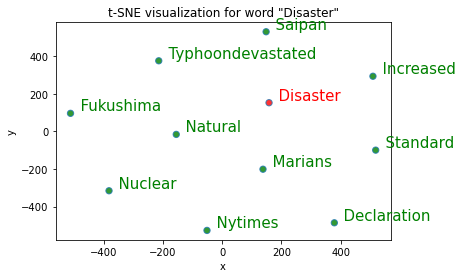

In [22]:
tsne_plot('disaster', ld_fs_model)

In [23]:
# Embedding the word using the fasttext index for each word
def embedding_matrix(sentence):
    embedding_matrix = np.zeros(len(sentence))
    for i, word in enumerate(sentence):
        try:
            embedding_matrix[i] = ld_fs_model.wv.key_to_index[word]
        except:
            embedding_matrix[i] = 0
            
    return embedding_matrix

In [24]:
X = train_data['preprocess_text'].apply(lambda x: embedding_matrix(x))
X.shape

(7613,)

In [25]:
# Padding the input sequence to get same length for all the inputs
embedded_matrix_X = pad_sequences(X, padding='pre', maxlen=50, dtype='float64')
embedded_matrix_X

array([[   0.,    0.,    0., ..., 1475.,    0.,    8.],
       [   0.,    0.,    0., ...,    0.,    0., 1218.],
       [   0.,    0.,    0., ...,  507.,  419., 1042.],
       ...,
       [   0.,    0.,    0., ...,  484., 1373.,    0.],
       [   0.,    0.,    0., ...,    0., 2445.,   96.],
       [   0.,    0.,    0., ...,  566.,   14.,    0.]])

In [26]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(embedded_matrix_X, train_data['target'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6090, 50), (1523, 50), (6090,), (1523,))

In [27]:
# Sequential model with embedding layer and BiLSTM Layer for fasttext embedding
lstm_model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=100000,
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.3, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(5e-5),
              metrics=['accuracy'])

lstm_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          6400000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 6,470,209
Trainable params: 6,470,209
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = lstm_model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=7, batch_size=60)

Epoch 1/7
102/102 [==============================] - 32s 214ms/step - loss: 0.6911 - accuracy: 0.5660 - val_loss: 0.6892 - val_accuracy: 0.5739
Epoch 2/7
102/102 [==============================] - 21s 201ms/step - loss: 0.6866 - accuracy: 0.5695 - val_loss: 0.6837 - val_accuracy: 0.5739
Epoch 3/7
102/102 [==============================] - 21s 202ms/step - loss: 0.6780 - accuracy: 0.5696 - val_loss: 0.6716 - val_accuracy: 0.5745
Epoch 4/7
102/102 [==============================] - 20s 192ms/step - loss: 0.6528 - accuracy: 0.6291 - val_loss: 0.6362 - val_accuracy: 0.6835
Epoch 5/7
102/102 [==============================] - 21s 202ms/step - loss: 0.5948 - accuracy: 0.7473 - val_loss: 0.5825 - val_accuracy: 0.7800
Epoch 6/7
102/102 [==============================] - 23s 223ms/step - loss: 0.5216 - accuracy: 0.8169 - val_loss: 0.5326 - val_accuracy: 0.7873
Epoch 7/7
102/102 [==============================] - 21s 204ms/step - loss: 0.4589 - accuracy: 0.8381 - val_loss: 0.5023 - val_accuracy:

              precision    recall  f1-score   support

     Class 0       0.80      0.85      0.82       874
     Class 1       0.78      0.71      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



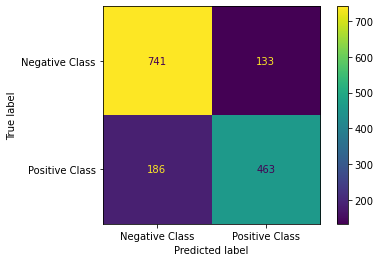

In [29]:
# Performace metrics for LSTM model
y_pred = lstm_model_2.predict(X_test)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
report_lstm_2 = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
print(report_lstm_2)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative Class', 'Positive Class'])
disp.plot(values_format='d')

## Using BERT Pre-Trained model for preprocessing

In [30]:
# Downloading the BERT Model for tokenization
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

INFO:absl:Using C:\Users\Venkat\AppData\Local\Temp\tfhub_modules to cache modules.


In [31]:
# Loading the Dataset
train_data['preprocess_text'] = train_data['text'].apply(lambda x: preprocess(x))

In [32]:
# Converting the tokens into token ids
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize(text_reviews))

In [33]:
tokens = tokenizer.convert_tokens_to_ids('disaster')
tokens

[1040, 1045, 1055, 1037, 1055, 1056, 1041, 1054]

In [34]:
X = train_data['preprocess_text'].apply(lambda x: tokenize_reviews(x))
len(X)

7613

In [35]:
# Padding the input sequence to get same length for all the inputs
embedded_matrix_bert = pad_sequences(X, padding='pre', maxlen=35, dtype='float64')
embedded_matrix_bert, len(tokenizer.vocab)

(array([[    0.,     0.,     0., ..., 16455.,  9641.,  1057.],
        [    0.,     0.,     0., ..., 21871.,  2243.,  2710.],
        [    0.,     0.,     0., ...,  2173.,  2344.,  3517.],
        ...,
        [    0.,     0.,     0., ...,  3207.,  2497.,  3501.],
        [    0.,     0.,     0., ..., 15509.,  8701.,  4544.],
        [    0.,     0.,     0., ..., 27472.,  4160.,  2094.]]),
 30522)

In [36]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(embedded_matrix_bert, train_data['target'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6090, 35), (1523, 35), (6090,), (1523,))

In [37]:
# Sequential model with embedding layer, Conv1D layer and Bi-LSTM layer for BERT embedding
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=30522,
        output_dim=128,
        mask_zero=True),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(5e-5),
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         3906816   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          24640     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          6176      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)         

In [38]:
history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, batch_size=10)

Epoch 1/4
609/609 [==============================] - 50s 69ms/step - loss: 0.6807 - accuracy: 0.5695 - val_loss: 0.6709 - val_accuracy: 0.5732
Epoch 2/4
609/609 [==============================] - 39s 63ms/step - loss: 0.6360 - accuracy: 0.6294 - val_loss: 0.5453 - val_accuracy: 0.7551
Epoch 3/4
609/609 [==============================] - 41s 67ms/step - loss: 0.4189 - accuracy: 0.8269 - val_loss: 0.4552 - val_accuracy: 0.7945
Epoch 4/4
609/609 [==============================] - 41s 68ms/step - loss: 0.2983 - accuracy: 0.8874 - val_loss: 0.4835 - val_accuracy: 0.7886


              precision    recall  f1-score   support

     Class 0       0.79      0.85      0.82       874
     Class 1       0.78      0.70      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



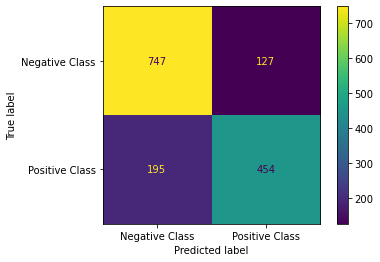

In [39]:
# Performace metrics for Conv1D and LSTM model
y_pred = cnn_model.predict(X_test)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
cnn_report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
print(cnn_report)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative Class', 'Positive Class'])
disp.plot(values_format='d')

## BERT Model for Training 

In [40]:
train_data = pd.read_csv('train.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Preprocessing text for BERT

In [41]:
# Preprocessing text into input format
def preprocess(text):

    # Removing Punctuation from the text
    punct = [words for words in text[3] if words not in string.punctuation ]
    words = ''.join(punct)
    
    # Tokenizing the text
    tokens = nltk.word_tokenize(words)
    tokens.append(str(text[1]))
    tokens.append(str(text[2]))
    
    # Removing emojis, emails, numbers

    lemmatized_output = ' '.join(tokens)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', lemmatized_output, flags=re.MULTILINE)
    text = re.sub('<.*?>+', '', text)
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F" 
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags = re.UNICODE)
    
    text = regrex_pattern.sub(r'',text)
    text = ''.join([i for i in text if not i.isdigit()])
    
    return text

In [42]:
train_data['preprocess_text'] = train_data.apply(lambda x: preprocess(x), axis=1)
train_data.head()

,id,keyword,location,text,target,preprocess_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada nan nan
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...


In [43]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(train_data['preprocess_text'], train_data['target'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6090,), (1523,), (6090,), (1523,))

In [44]:
import tensorflow_text

max_seq_length = 128

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string) # Creating a input layer
preprocessor = hub.KerasLayer(
   "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3") # Downloading BERT model for embedding
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)  # Downloading the BERT model for training
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

In [45]:
# Adding Dense Layer and output layer for classification
dense_1 = tf.keras.layers.Dense(64, activation='relu')(pooled_output)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='Output')(dense_1)

In [46]:
# Compiling the BERT Model
bert_model = tf.keras.Model(text_input, output)
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'input_type_ids': ( 0           input_1[0][0]                    
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      {'default': (None, 7 109482241   keras_layer_1[0][0]              
                                                                 keras_layer_1[0][1]              
                                                                 keras_layer_1[0][2]              
______________________________________________________________________________________________

In [ ]:
# Training the BERT model
epochs = 2
history = bert_model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=epochs,
                    verbose=1)

In [ ]:
import os

# Saving and loading the model
bert_model.save('./bert')
bert_model = tf.keras.models.load_model('./bert')
bert_model.summary()

In [ ]:
# Performace metrics for BERT model
y_pred = bert_model.predict(X_test)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
bert_report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
print(bert_report)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative Class', 'Positive Class'])
disp.plot(values_format='d')